In [1]:
import itertools

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch import nn
from torch import distributions
from torch.distributions import MultivariateNormal

from nflib.flows import MAF, NormalizingFlowModel

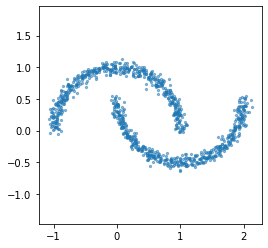

In [2]:
from sklearn import datasets

class TwoHalfMoons:
    def sample(self, n):
        moons = datasets.make_moons(n_samples=n, noise=0.05)[0].astype(np.float32)
        return torch.from_numpy(moons)

d = TwoHalfMoons()

x = d.sample(1024)
plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.axis('equal');

In [3]:
class GaussianMixture:
    def __init__(self, dim):
        self.left = MultivariateNormal(-2 * torch.ones(dim), torch.eye(dim))
        self.right = MultivariateNormal(2 * torch.ones(dim), torch.eye(dim))
    def sample(self, n):
        self.left_samples = self.left.sample(n)
        self.right_samples = self.right.sample(n)
        mask = np.random.binomial((1,), p=0.5, size=(n[0],1))
        mask = np.repeat(mask, 2, axis=1)
        return self.left_samples * mask + self.right_samples * (1 - mask)
    
    def log_prob(self, z):
        self.log_p_left = self.left.log_prob(z)
        self.log_p_right = self.right.log_prob(z)

        self.p_left = torch.exp(self.log_p_left)
        self.p_right = torch.exp(self.log_p_right)

        self.left_conditional = self.p_left / (self.p_left + self.p_right)
        return torch.log(self.p_left * self.left_conditional + self.p_right * (1 - self.left_conditional))

In [4]:
# construct a model
#prior = MultivariateNormal(torch.zeros(2), torch.eye(2))
prior = GaussianMixture(2)
# MAF (with MADE net, so we get very fast density estimation)
flows = [MAF(dim=2, parity=1) for i in range(8)]
#flows = [MAF(dim=2, parity=i%2) for i in range(8)]

# construct the model
model = NormalizingFlowModel(prior, flows)

In [5]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  10976


In [6]:
model.train()
for k in range(16000):
    x = d.sample(64)
    
    zs, prior_logprob, log_det = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob) # NLL

    model.zero_grad()
    loss.backward()
    optimizer.step()

    if k % 100 == 0:
        print(k, loss.item())


0 281.1641845703125
100 186.14910888671875
200 126.62460327148438
300 116.74066162109375
400 112.1055908203125
500 109.67301940917969
600 102.54183959960938
700 96.12393188476562
800 88.34598541259766
900 82.65625
1000 77.42845916748047
1100 77.09043884277344
1200 65.48020935058594
1300 67.66267395019531
1400 64.10724639892578
1500 65.44470977783203
1600 56.691688537597656
1700 47.41860580444336
1800 55.051082611083984
1900 53.45697021484375
2000 54.8441047668457
2100 59.5834846496582
2200 46.14494705200195
2300 42.60201644897461
2400 41.39910125732422
2500 40.13059616088867
2600 39.6945915222168
2700 37.1241455078125
2800 33.62582778930664
2900 31.467021942138672
3000 29.15873908996582
3100 33.53462600708008
3200 27.334774017333984
3300 22.345598220825195
3400 23.128753662109375
3500 34.063140869140625
3600 15.70819091796875
3700 30.40376853942871
3800 29.324359893798828
3900 34.095577239990234
4000 12.88427448272705
4100 17.360118865966797
4200 20.362197875976562
4300 13.669152259826

Text(0.5, 1.0, 'x -> z')

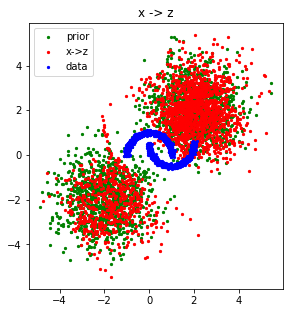

In [9]:
model.eval()

batch_size = 2048
x = d.sample(batch_size)
z, prior_logprob, log_det = model(x)

x = x.detach().numpy()
z = z.detach().numpy()
p = model.prior.sample([batch_size, ]).squeeze()
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(p[:,0], p[:,1], c='g', s=5, label='prior')
plt.scatter(z[:,0], z[:,1], c='r', s=5, label='x->z')
plt.scatter(x[:,0], x[:,1], c='b', s=5, label='data')
plt.legend()

plt.axis('scaled')
plt.title('x -> z')